<a href="https://colab.research.google.com/github/suredream/PyTorch-Lightning-Ace/blob/main/pll_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q pytorch_lightning

     |████████████████████████████████| 585 kB 36.8 MB/s 
     |████████████████████████████████| 596 kB 61.1 MB/s 
     |████████████████████████████████| 140 kB 72.3 MB/s 
     |████████████████████████████████| 419 kB 67.2 MB/s 
     |████████████████████████████████| 1.1 MB 45.1 MB/s 
     |████████████████████████████████| 271 kB 53.0 MB/s 
     |████████████████████████████████| 144 kB 74.0 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, 

---------------------------------------------------------------------------------------------------------
|   epoch    |    time    |    loss    |    acc     |     f1     |  val_loss  |  val_acc   |   val_f1   |
---------------------------------------------------------------------------------------------------------
|     0      |     1      |  0.172967  |  0.948183  |  0.947800  |  0.049784  |  0.983400  |  0.983301  |
|     1      |     1      |  0.051743  |  0.983983  |  0.983874  |  0.039947  |  0.985900  |  0.985830  |
|     2      |     1      |  0.034677  |  0.989133  |  0.989069  |  0.041801  |  0.986400  |  0.986271  |
|     3      |     1      |  0.025729  |  0.991683  |  0.991674  |  0.035213  |  0.989600  |  0.989465  |
|     4      |     1      |  0.018311  |  0.994350  |  0.994332  |  0.028052  |  0.990600  |  0.990513  |
|     5      |     1      |  0.014890  |  0.994767  |  0.994752  |  0.028894  |  0.990200  |  0.990099  |
|     6      |     1      |  0.011349  |  0.99

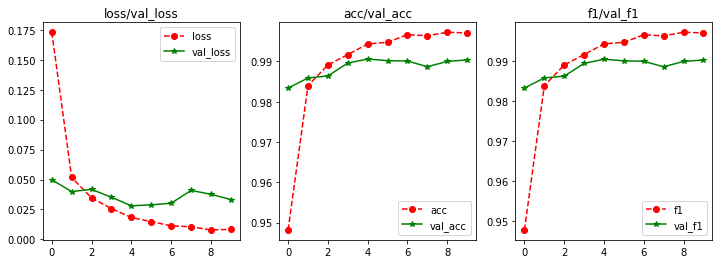

In [13]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import *
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback

import os, gc, time
import math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import *

# 定义超参数
epochs = 10
batch_size = 128


# 创建数据集和生成器
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])



train_dataset = datasets.MNIST("data", train=True, download=True, transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = datasets.MNIST("data", train=False, transform=val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# 定义损失函数和指标


class CrossEntropyLoss(Module): # 和Pytorch官方实现一样
    def __init__(self):
        super().__init__()

    def forward(self, input, target, reduction="mean"):
        N, C = input.size()

        if target.dim() > 1:
            one_hot = target
        else:
            one_hot = torch.zeros((N, C), dtype=input.dtype, device=input.device)
            one_hot.scatter_(1, target.reshape(N, 1), 1)

        loss = -(one_hot * F.log_softmax(input, 1)).sum(1)
        if reduction == "mean":
            return loss.mean(0)
        elif reduction == "sum":
            return loss.sum(0)
        else:
            return loss


class ClassificationMetric(object): # 记录结果并计算指标
    def __init__(self, accuracy=True, recall=True, precision=True, f1=True, average="macro"):
        self.accuracy = accuracy
        self.recall = recall
        self.precision = precision
        self.f1 = f1
        self.average = average

        self.preds = []
        self.target = []

    def reset(self): # 重置结果
        self.preds.clear()
        self.target.clear()
        gc.collect()

    def update(self, preds, target): # 更新结果
        preds = list(preds.cpu().detach().argmax(1).numpy())
        target = list(target.cpu().detach().argmax(1).numpy()) if target.dim() > 1 else list(target.cpu().detach().numpy())
        self.preds += preds
        self.target += target

    def compute(self): # 计算结果
        metrics = []
        if self.accuracy:
            metrics.append(accuracy_score(self.target, self.preds))
        if self.recall:
            metrics.append(recall_score(self.target, self.preds, labels=list(set(self.preds)), average=self.average))
        if self.precision:
            metrics.append(precision_score(self.target, self.preds, labels=list(set(self.preds)), average=self.average))
        if self.f1:
            metrics.append(f1_score(self.target, self.preds, labels=list(set(self.preds)), average=self.average))
        self.reset()
        return metrics


# 定义模型和训练逻辑


class CustomModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # 定义网络层
        self.conv1 = Conv2d(1, 10, 5)
        self.conv2 = Conv2d(10, 20, 3)
        self.fc1 = Linear(20*10*10, 500)
        self.fc2 = Linear(500, 10)
        # 定义损失函数
        self.train_criterion = CrossEntropyLoss()
        self.val_criterion = CrossEntropyLoss()
        # 定义指标
        self.train_metric = ClassificationMetric(recall=False, precision=False)
        self.val_metric = ClassificationMetric(recall=False, precision=False)
        # 定义log
        self.history = {
            "loss": [], "acc": [], "f1": [],
            "val_loss": [], "val_acc": [], "val_f1": [],
        }
        
    def forward(self,x):
        in_size = x.size(0)
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)
        out = self.conv2(out)
        out = F.relu(out)
        out = out.view(in_size, -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out
    
    def training_step(self, batch, idx):
        x, y = batch
        _y = self(x)
        # 计算loss
        loss = self.train_criterion(_y, y)
        # 更新结果
        self.train_metric.update(_y, y)
        return loss

    def training_epoch_end(self, outs):
        # 计算平均loss
        loss = 0.
        for out in outs:
            loss += out["loss"].cpu().detach().item()
        loss /= len(outs)
        # 计算指标
        acc, f1 = self.train_metric.compute()
        # 记录log
        self.history["loss"].append(loss)
        self.history["acc"].append(acc)
        self.history["f1"].append(f1)

    def validation_step(self, batch, idx):
        x, y = batch
        _y = self(x)
        val_loss = self.val_criterion(_y, y)
        self.val_metric.update(_y, y)
        return val_loss

    def validation_epoch_end(self, outs):
        val_loss = sum(outs).item() / len(outs)
        val_acc, val_f1 = self.val_metric.compute()

        self.history["val_loss"].append(val_loss)
        self.history["val_acc"].append(val_acc)
        self.history["val_f1"].append(val_f1)

    def configure_optimizers(self):
        # 设置优化器
        return Adam(self.parameters())



model = CustomModel()


# 定义进度条和学习曲线
class FlexibleTqdm(Callback):
    def __init__(self, steps, column_width=10):
        super(FlexibleTqdm, self).__init__()
        self.steps = steps
        self.column_width = column_width
        self.info = "\rEpoch_%d %s%% [%s]"

    def on_train_start(self, trainer, module):
        history = module.history
        self.row = "-" * (self.column_width + 1) * (len(history) + 2) + "-"
        title = "|"
        title += "epoch".center(self.column_width) + "|"
        title += "time".center(self.column_width) + "|"
        for i in history.keys():
            title += i.center(self.column_width) + "|"
        print(self.row)
        print(title)
        print(self.row)

    def on_train_batch_end(self, trainer, module, outputs, batch, batch_idx, dataloader_idx):
        current_index = int((batch_idx + 1) * 100 / self.steps)
        tqdm = ["."] * 100
        for i in range(current_index - 1):
            tqdm[i] = "="
        if current_index:
            tqdm[current_index - 1] = ">"
        print(self.info % (module.current_epoch, str(current_index).rjust(3), "".join(tqdm)), end="")

    def on_epoch_start(self, trainer, module):
        print(self.info % (module.current_epoch, "  0", "." * 100), end="")
        self.begin = time.perf_counter()

    # LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated
    # `Callback.on_<train/validation/test>_epoch_end
    def on_train_epoch_end(self, trainer, module):
        self.end = time.perf_counter()
        history = module.history
        detail = "\r|"
        detail += str(module.current_epoch).center(self.column_width) + "|"
        detail += ("%d" % (self.end - self.begin)).center(self.column_width) + "|"
        for j in history.values():
            if j:
                # print(j)
                detail += ("%.06f" % j[-1]).center(self.column_width) + "|"
        print("\r" + " " * 120, end="")
        print(detail)
        # print(self.row)
        
        
class LearningCurve(Callback):
    def __init__(self, figsize=(12, 4), names=("loss", "acc", "f1")):
        super(LearningCurve, self).__init__()
        self.figsize = figsize
        self.names = names

    def on_fit_end(self, trainer, module):
        history = module.history
        plt.figure(figsize=self.figsize)
        for i, j in enumerate(self.names):
            plt.subplot(1, len(self.names), i + 1)
            plt.title(j + "/val_" + j)
            plt.plot(history[j], "--o", color='r', label=j)
            plt.plot(history["val_" + j], "-*", color='g', label="val_" + j)
            plt.legend()
        plt.show()


# 设置训练参数（我不喜欢用logger，所以全关闭了）


trainer_params = {
    "gpus": 1,
    "max_epochs": epochs,  # 1000
    "checkpoint_callback": False,  # True
    "logger": False,  # TensorBoardLogger
    "progress_bar_refresh_rate": 0,  # 1
    "num_sanity_val_steps": 0,  # 2
    "callbacks": [
        FlexibleTqdm(len(train_dataset) // batch_size, column_width=12), # 注意设置progress_bar_refresh_rate=0，取消自带的进度条
        LearningCurve(figsize=(12, 4), names=("loss", "acc", "f1")),
    ],  # None
}
trainer = pl.Trainer(**trainer_params)
trainer.fit(model, train_dataloader, val_dataloader)